## QUERY LOCALIZER EXPERIMENT

Целью данного эксперимента является нахождение позы нового изображения на основе уже имеющейся реконструкции SfM. Здесь описан пайплайн, когда мы сами создаем SfM при помощи аппрата PixSfM. Вы можете также использовать уже готовую SfM.

# Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars

from pathlib import Path
import pycolmap
import sys

sys.path.append("/workspace/pixel-perfect-sfm/")
sys.path.append("/workspace/pixel-perfect-sfm/Hierarchical-Localization")

from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap
from hloc.utils.read_write_model import  write_next_bytes, Point3D, Image, read_images_text, read_points3D_binary,\
        write_points3D_binary, write_images_binary, read_images_binary, write_images_text, read_cameras_binary, \
        Camera, write_cameras_text, read_cameras_text

from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect

import numpy as np
from matplotlib import pyplot as plt

import open3d as o3d
assert o3d.__version__ == '0.15.2', 'The version 0.15.2 is required!'

# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Setup

В **object_name** необходимо задать имя объекта, над которым вы хотите провести эксперимент.

**check_for_calibrated_images** - булевая переменная, по которой мы выбираем какие поз камер использовать (менее точные (True) или точные (False))

**delete_previous_output** - если True, то удаляет все предыдущие файлы в папке outputs. Использовать супер осторожно.

In [2]:
object_name = 'dragon'

check_for_calibrated_images = False
delete_previous_output = False

**images_all** - путь к папке со всеми изображениями

**outputs** - путь к папке со всеми результатами

**cache_init** - путь к кэш-файлу, его мы получаем во время того, когда делаем KA или BA. В этот файле хранятся featuremaps после  dense feature extraction. В среднем на одну картинку размером 2368х1952 уходит 3 минуты. Этот файл вообще нельзя трогать, поэтому мы копируем его в папку outputs для своего эксперимента и продолжаем работу.

**cache_path** - тот же файл, что cache_init, с которым мы теперь будем работать во время эксперимента.

**sfm_pairs** - файл с названиями пар изображений на каждой строке

**features** - файл с features для каждой картинки, извлеченными при помощи feature_conf

**matches** - файл с matches для каждой пары картинок, извлеченными при помощи matcher_conf

**pairs-loc.txt** - файл с названиями пар изображений на каждой строке (только на этот раз идут пары для картинок из ДБ со всеми возможными картинками из папки query)

In [3]:
root = Path('/workspace')

images_all = root / f'datasets/sk3d/dataset/{object_name}/tis_right/rgb/undistorted/ambient@best'

cameras_init = root / 'datasets/sk3d/dataset/calibration/tis_right/rgb/cameras.txt'

outputs = root / (f'pixel-perfect-sfm/outputs/{object_name}/query_loc_auto_intrinsics')

if delete_previous_output:
    !rm -rf $outputs
    
outputs.mkdir(parents=True, exist_ok=True)

sfm_pairs = outputs / 'pairs-sfm.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'
loc_pairs = outputs / 'pairs-loc.txt'

exp_loc = outputs / "localizer"
exp_loc.mkdir(parents=True, exist_ok=True)

In [4]:
cache_init = root / f'pixel-perfect-sfm/outputs/caches/{object_name}/s2dnet_featuremaps_sparse.h5'
!cp -r $cache_init $outputs
cache_path = outputs / 's2dnet_featuremaps_sparse.h5'

# 3D mapping and refinement

Здесь описаны возможности для настройки [**extract_features**](https://github.com/cvg/Hierarchical-Localization/blob/91f40bfd765add3b59ba7376f8579d8829f7fa78/hloc/extract_features.py#L21)

Здесь описаны возможности для настройки [**match_features**](https://github.com/cvg/Hierarchical-Localization/blob/91f40bfd765add3b59ba7376f8579d8829f7fa78/hloc/match_features.py#L17)

Здесь описан пайплайн того, как можно использовать свои кастомные [**local features**, **matcher**, **image retrieval**](https://github.com/cvg/Hierarchical-Localization/tree/91f40bfd765add3b59ba7376f8579d8829f7fa78#using-your-own-local-features-or-matcher).


In [5]:
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

## Create db and query images

Создаем две папки: mapping и query. В папке mapping будут лежать все те картинки, которые нужны нам для построения реконструкции.  В папке query будут находиться все те картинки, для которых мы хотим новую позы.

In [6]:
import shutil

images = root / f'pixel-perfect-sfm/dataset/{object_name}_loc'
images.mkdir(parents=True, exist_ok=True)

images_references = root / f'pixel-perfect-sfm/dataset/{object_name}_loc/mapping'
images_references.mkdir(parents=True, exist_ok=True)
ref_num = 3

images_queries = root / f'pixel-perfect-sfm/dataset/{object_name}_loc/query'
images_queries.mkdir(parents=True, exist_ok=True)

img_list = sorted([str(p) for p in images_all.iterdir()])
for fn in img_list[:ref_num]: shutil.copy(fn, str(images_references)) 
for fn in img_list[ref_num:100]: shutil.copy(fn, str(images_queries)) 
    
!echo "All image references: " && ls $images_references
!echo "All image queries: " && ls $images_queries

All image references: 
0000.png  0001.png  0002.png
All image queries: 
0003.png  0016.png  0029.png  0042.png	0055.png  0068.png  0081.png  0094.png
0004.png  0017.png  0030.png  0043.png	0056.png  0069.png  0082.png  0095.png
0005.png  0018.png  0031.png  0044.png	0057.png  0070.png  0083.png  0096.png
0006.png  0019.png  0032.png  0045.png	0058.png  0071.png  0084.png  0097.png
0007.png  0020.png  0033.png  0046.png	0059.png  0072.png  0085.png  0098.png
0008.png  0021.png  0034.png  0047.png	0060.png  0073.png  0086.png  0099.png
0009.png  0022.png  0035.png  0048.png	0061.png  0074.png  0087.png
0010.png  0023.png  0036.png  0049.png	0062.png  0075.png  0088.png
0011.png  0024.png  0037.png  0050.png	0063.png  0076.png  0089.png
0012.png  0025.png  0038.png  0051.png	0064.png  0077.png  0090.png
0013.png  0026.png  0039.png  0052.png	0065.png  0078.png  0091.png
0014.png  0027.png  0040.png  0053.png	0066.png  0079.png  0092.png
0015.png  0028.png  0041.png  0054.png	0067.png  008

Здесь мы проверяем какие изображения мы будем использовать для построения реконструкции SfM.

['0000.png', '0001.png', '0002.png']
3 mapping images


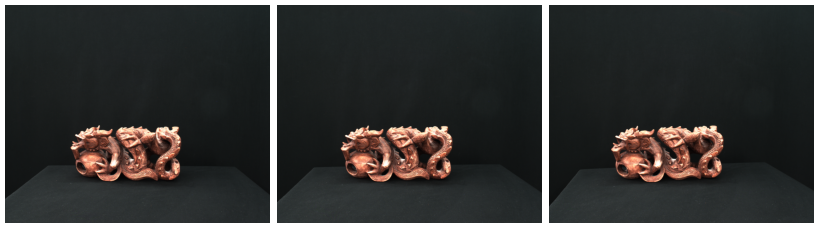

In [7]:
references = [str(p.relative_to(images_references)) for p in images_references.iterdir()]
print(references)
print(len(references), "mapping images")
plot_images([read_image(images_references / r) for r in references[:ref_num]], dpi=50)

**extract_features** - данная функция получает на вход *feature_conf*, *images* (путь к папке с изображениями), *image_list* (список тех изображений, которые вы хотите использовать для feature exctraction), *feature_path* (путь к файлу, где будет сохранен результат). На выходе получаем файл (**features**) с извлеченными features. Если **features** существует, то пропускается.

**pairs_from_exhaustive** - данная функция получает на вход *sfm_pairs* (путь к файлу, где будет сохранен результат), *image_list* (список тех изображений, при помощи которых вы сделаете exhaustive pairs.) На выходе получаем файл (**sfm_pairs**) с парами изображений.  Если **sfm_pairs** существует, то пропускается.

**match_features** - данная функция получает на вход *matcher_conf*, *sfm_pairs* (путь к файлу, где хранятся пары изображений после exhaustive pairing), *features* (путь к файлу, где хранятся извлеченный features для каждого изображения), *matches* (путь к файлу, где хранятся matches для каждой пары изображения). На выходе получаем файл (**matches**) с matches для каждой пары изображений . Если **match_features** существует, то пропускается.


In [8]:
extract_features.main(feature_conf, 
                      images_all, 
                      image_list=references, 
                      feature_path=features)

pairs_from_exhaustive.main(sfm_pairs, 
                           image_list=references)

match_features.main(matcher_conf, 
                    sfm_pairs, 
                    features=features, 
                    matches=matches);

[2022/10/15 02:51:13 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2022/10/15 02:51:13 hloc INFO] Skipping the extraction.
[2022/10/15 02:51:13 hloc INFO] Found 3 pairs.
[2022/10/15 02:51:13 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2022/10/15 02:51:13 hloc INFO] Skipping the matching.


После того как мы получили features и matches для картинок из папки mapping, мы можем приступить к построению реконструкции при помощи PixSfM. 

Здесь описано как можно настроить конфигурацию для КА и ВА. https://github.com/cvg/pixel-perfect-sfm#detailed-configuration

In [9]:
# run pixsfm

conf = {
        "dense_features": {
                "use_cache": False,
        },
         "KA": {
                "dense_features": {'use_cache': True}, 
                "split_in_subproblems": True,
                "max_kps_per_problem": 1000,  
            },
        
        "BA": { 
                "apply": True,
                "optimizer": {
                      "refine_focal_length": False,  # whether to optimize the focal length
                      "refine_principal_point": False,  # whether to optimize the principal points
                      "refine_extra_params": False,  # whether to optimize distortion parameters
                      "refine_extrinsics": True,  # whether to optimize the camera poses
                }
            }
}


_cams = read_cameras_text(str(cameras_init))
f, cx, cy, k = _cams[0].params

opts = dict(camera_model='PINHOLE', 
            camera_params=','.join(map(str, (f, cx, cy, k))))

hloc_args = dict(
                camera_mode=pycolmap.CameraMode.SINGLE,
                verbose=True,
                #image_options=opts
)
print(hloc_args)


sfm = PixSfM(conf)
model, sfm_outputs = sfm.reconstruction(exp_loc, 
                                          images_all, 
                                          sfm_pairs, 
                                          features, 
                                          matches, 
                                          image_list=references, 
                                          **hloc_args)

print(model.summary())

{'camera_mode': <CameraMode.SINGLE: 1>, 'verbose': True}


[2022/10/15 02:51:15 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /workspace/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2022/10/15 02:51:21 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1600,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}
[2022/10/15 02:51:21 pixsfm INFO] Building matching graph...
[2022/10/15 02:51:21 pixsfm INFO] Extracting dense features...


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/15 02:51:22 pixsfm INFO] Computing tracks...
[2022/10/15 02:51:22 pixsfm INFO] # graph nodes: 1394
[2022/10/15 02:51:22 pixsfm INFO] # graph edges: 1217
[2022/10/15 02:51:22 pixsfm INFO] # tracks: 523
[2022/10/15 02:51:22 pixsfm INFO] Start feature-metric keypoint adjustment.


100%[████████████████████] 1394/1394 [00:00, 2821.86it/s]


[2022/10/15 02:51:23 pixsfm INFO] KA Time: 0.495496s, cost change: 0.0214498 --> 0.0157947


[2022/10/15 02:51:23 hloc WARNING] The database already exists, deleting it.
[2022/10/15 02:51:23 hloc INFO] Creating an empty database...
[2022/10/15 02:51:23 hloc INFO] Importing images into the database...
[2022/10/15 02:51:24 hloc INFO] Importing features into the database...


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/15 02:51:24 hloc INFO] Importing matches into the database...


  0%|          | 0/3 [00:00<?, ?it/s]

[2022/10/15 02:51:24 hloc INFO] Performing geometric verification of the matches...



Custom feature matching

Matching block [1/1] in 0.069s
Elapsed time: 0.002 [minutes]


[2022/10/15 02:51:24 hloc INFO] Running 3D reconstruction...



Loading database

Loading cameras... 1 in 0.001s
Loading matches... 3 in 0.001s
Loading images... 3 in 0.002s (connected 3)
Building correspondence graph... in 0.002s (ignored 0)

Elapsed time: 0.000 [minutes]


Finding good initial image pair

  => No good initial image pair found.
  => Relaxing the initialization constraints.

Finding good initial image pair

  => No good initial image pair found.
  => Relaxing the initialization constraints.

Finding good initial image pair


Initializing with image pair #1 and #3


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  9.791812e+01    0.00e+00    1.89e+03   0.00e+00   0.00e+00  1.00e+04        0    8.94e-04    2.25e-03
   1  8.120034e+01    1.67e+01    8.27e+02   1.43e-01   9.98e-01  3.00e+04        1    1.60e-03    4.53e-03
   2  8.029303e+01    9.07e-01    2.88e+02   1.56e+00   1.01e+00  9.00e+04        1    1.44e-03    6.65e-03
   3  8.027048e+

  61  7.942103e+01    1.21e-02    4.88e+02   4.95e+00   5.83e-01  5.19e+05        1    1.45e-03    1.33e-01
  62  7.940910e+01    1.19e-02    4.82e+02   4.92e+00   5.84e-01  5.22e+05        1    1.47e-03    1.36e-01
  63  7.939731e+01    1.18e-02    4.77e+02   4.90e+00   5.84e-01  5.24e+05        1    1.49e-03    1.38e-01
  64  7.938565e+01    1.17e-02    4.72e+02   4.87e+00   5.85e-01  5.27e+05        1    1.48e-03    1.40e-01
  65  7.937414e+01    1.15e-02    4.67e+02   4.84e+00   5.85e-01  5.29e+05        1    1.49e-03    1.42e-01
  66  7.936277e+01    1.14e-02    4.62e+02   4.82e+00   5.86e-01  5.32e+05        1    1.47e-03    1.44e-01
  67  7.935153e+01    1.12e-02    4.57e+02   4.79e+00   5.87e-01  5.35e+05        1    1.48e-03    1.46e-01
  68  7.934044e+01    1.11e-02    4.52e+02   4.76e+00   5.87e-01  5.38e+05        1    1.44e-03    1.49e-01
  69  7.932948e+01    1.10e-02    4.47e+02   4.74e+00   5.88e-01  5.41e+05        1    1.44e-03    1.51e-01
  70  7.931867e+01    1.08e-

   Iterations : 16
         Time : 0.0542619 [s]
 Initial cost : 0.309194 [px]
   Final cost : 0.306995 [px]
  Termination : Convergence

  => Completed observations: 0
  => Merged observations: 0
  => Filtered observations: 0
  => Changed observations: 0.000000
  => Filtered images: 0

Elapsed time: 0.017 [minutes]


[2022/10/15 02:51:25 hloc INFO] Reconstructed 1 model(s).
[2022/10/15 02:51:25 hloc INFO] Largest model is #0 with 3 images.
[2022/10/15 02:51:25 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 3
	num_cameras = 1
	num_points3D = 390
	num_observations = 1114
	mean_track_length = 2.85641
	mean_observations_per_image = 371.333
	mean_reprojection_error = 0.350431
	num_input_images = 3


[2022/10/15 02:51:25 pixsfm INFO] Extracting references.


100%[████████████████████] 390/390 [00:00, 55714.2it/s]


[2022/10/15 02:51:25 pixsfm INFO] Reference Extraction Time: 0.050139s
[2022/10/15 02:51:25 pixsfm INFO] Start feature-reference bundle adjustment.


 95%[███████████████████░]  96/101 [00:01, 83.0449it/s]


[2022/10/15 02:51:26 pixsfm INFO] BA Time: 1.15528s, cost change: 0.0136509 --> 0.0132303
Reconstruction:
	num_reg_images = 3
	num_cameras = 1
	num_points3D = 390
	num_observations = 1114
	mean_track_length = 2.85641
	mean_observations_per_image = 371.333
	mean_reprojection_error = 0.350431


Перевод модели в формат TXT.

In [10]:
!mkdir -p $exp_loc/hloc/model_txt/ 

!colmap model_converter \
    --input_path $exp_loc/hloc/ \
    --output_path $exp_loc/hloc/model_txt/ \
    --output_type TXT

## Localization

Здесь мы можем проверить для каких изображений мы хотим найти новые позы.

97  queries images
['0003.png', '0004.png', '0005.png', '0006.png', '0007.png', '0008.png', '0009.png', '0010.png', '0011.png', '0012.png', '0013.png', '0014.png', '0015.png', '0016.png', '0017.png', '0018.png', '0019.png', '0020.png', '0021.png', '0022.png', '0023.png', '0024.png', '0025.png', '0026.png', '0027.png', '0028.png', '0029.png', '0030.png', '0031.png', '0032.png', '0033.png', '0034.png', '0035.png', '0036.png', '0037.png', '0038.png', '0039.png', '0040.png', '0041.png', '0042.png', '0043.png', '0044.png', '0045.png', '0046.png', '0047.png', '0048.png', '0049.png', '0050.png', '0051.png', '0052.png', '0053.png', '0054.png', '0055.png', '0056.png', '0057.png', '0058.png', '0059.png', '0060.png', '0061.png', '0062.png', '0063.png', '0064.png', '0065.png', '0066.png', '0067.png', '0068.png', '0069.png', '0070.png', '0071.png', '0072.png', '0073.png', '0074.png', '0075.png', '0076.png', '0077.png', '0078.png', '0079.png', '0080.png', '0081.png', '0082.png', '0083.png', '0084.pn

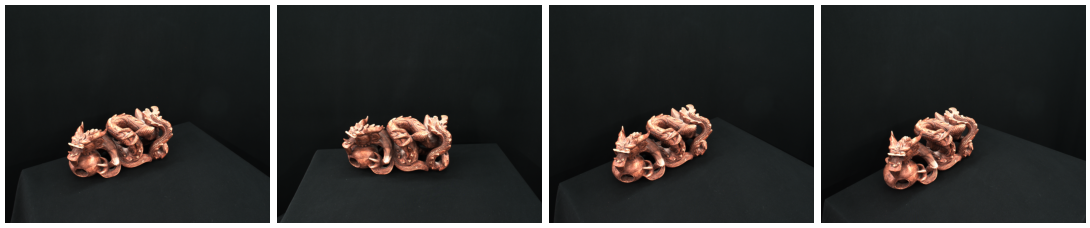

In [11]:
queries = [str(p.relative_to(images_queries)) for p in images_queries.iterdir()]
print(len(queries), " queries images")
print(sorted(queries))
plot_images([read_image(images_queries / r) for r in queries[:4]], dpi=50)

**features_query** - файл с features для каждой картинки из папки query, извлеченными при помощи feature_conf

**matches_query** - файл с matches для каждой пары картинок (mapping -> query), извлеченными при помощи matcher_conf

In [12]:
features_query = outputs / 'features_query.h5'
matches_query = outputs / 'matches_query.h5'

references_registered = [model.images[i].name for i in model.reg_image_ids()]

extract_features.main(feature_conf, 
                      images_all, 
                      image_list=queries, 
                      feature_path=features_query)

pairs_from_exhaustive.main(loc_pairs, 
                           image_list=queries, 
                           ref_list=references_registered)

[2022/10/15 02:51:32 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2022/10/15 02:51:32 hloc INFO] Skipping the extraction.
[2022/10/15 02:51:32 hloc INFO] Found 291 pairs.


In [13]:
match_features.main(matcher_conf, 
                    loc_pairs, 
                    features=features_query, 
                    matches=matches_query, 
                    features_ref=features);

[2022/10/15 02:51:32 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2022/10/15 02:51:32 hloc INFO] Skipping the matching.


На данном этапе мы создаем объект QueryLocalizer, который принимает *model* (pycolmap.Reconstruction объект, модель, на основе которой мы будем находить новые позы для изображений), *conf* (конфиг для query localizer), *dense_features* (dense features из SfM реконструкции).

Здесь описано как можно настроить конфигурацию для query localization. https://github.com/cvg/pixel-perfect-sfm#detailed-configuration

In [14]:
model = pycolmap.Reconstruction(exp_loc / 'hloc/model_txt/' )

In [15]:
import pycolmap
from pixsfm.localize import QueryLocalizer, pose_from_cluster

loc_conf = {
        "dense_features": sfm.conf.dense_features,  # same features as the SfM refinement
        "PnP": {  # initial pose estimation with PnP+RANSAC
            'estimation': {'ransac': {'max_error': 12.0}},
            'refinement': {'refine_focal_length': False, 
                           'refine_extra_params': False},
        },
        "QBA": {  # query pose refinement
            "optimizer:": {'refine_focal_length': False, 
                           'refine_extra_params': False},
        }
    }


ref_ids = [model.find_image_with_name(r).image_id for r in references_registered]
dense_features = sfm_outputs["feature_manager"]


# localizer computes references for the entire reconstruction at init
# Parameters:
# - config: Union[dict,DictConfig]: config of localization (use {} for default)
# - reconstruction: pycolmap.Reconstruction; reference COLMAP reconstruction
# - feature_manager: features of reference reconstruction

localizer = QueryLocalizer(model, 
                           conf=loc_conf, 
                           dense_features=dense_features)

[2022/10/15 02:51:34 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /workspace/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2022/10/15 02:51:34 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1600,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}


[2022/10/15 02:51:34 pixsfm INFO] Extracting references.


100%[████████████████████] 390/390 [00:00, 55714.2it/s]


[2022/10/15 02:51:34 pixsfm INFO] Reference Extraction Time: 0.015796s


Объявляем какие параметры камеры мы хотим использовать для того чтобы локализовать query ихображение. Тут я использую камеру с теми же параметрами, которые использовались для построения SfM на основе изображений из папки mapping.

In [16]:
_cams = read_cameras_binary(str(exp_loc / 'hloc/cameras.bin'))
cam_info = _cams[1]
print(_cams[1])

pinhole_camera = pycolmap.Camera(
                            model='PINHOLE',
                            width=cam_info.width,
                            height=cam_info.height,
                            params=cam_info.params)
    
print("Camera info --> ", pinhole_camera)

Camera(id=1, model='SIMPLE_RADIAL', width=2368, height=1952, params=array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02]))
Camera info -->  <Camera 'camera_id=Invalid, model=PINHOLE, width=2368, height=1952, num_params=4'>


# Query Localization (1 query)

Находим позу для первого query изображения при помощи функции **pose_cluster**. Под капотом, QueryLocalizer извлекает dense features для query изображения и прогоняет QKA (query keypoint adjustment) и QBA (query pose adjustment).

In [17]:
query = sorted(queries)[0]

ret, log = pose_from_cluster(localizer, 
                             query, 
                             pinhole_camera, 
                             ref_ids, 
                             features_query, 
                             matches_query, 
                             image_path=images_all / query)

[2022/10/15 02:51:34 pixsfm INFO] Start features exctraction.


None True


[2022/10/15 02:51:35 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:35 pixsfm INFO] Run QKA


[2022/10/15 02:51:35 pixsfm INFO] QKA Time: 0.101703s, cost change: 0.0462537 --> 0.0283531


[2022/10/15 02:51:35 pixsfm INFO] Running PnP with 342 correspondences.
[2022/10/15 02:51:35 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:35 pixsfm INFO]  Run QBA


[2022/10/15 02:51:35 pixsfm INFO] QBA Time: 0.206949s, cost change: 0.0261753 --> 0.0258429


[2022/10/15 02:51:35 pixsfm INFO] We recompute the inliers from the final pose


found 74/342 inlier correspondences.


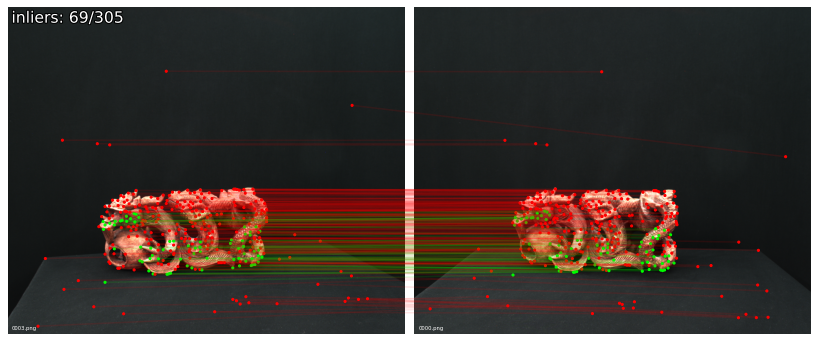

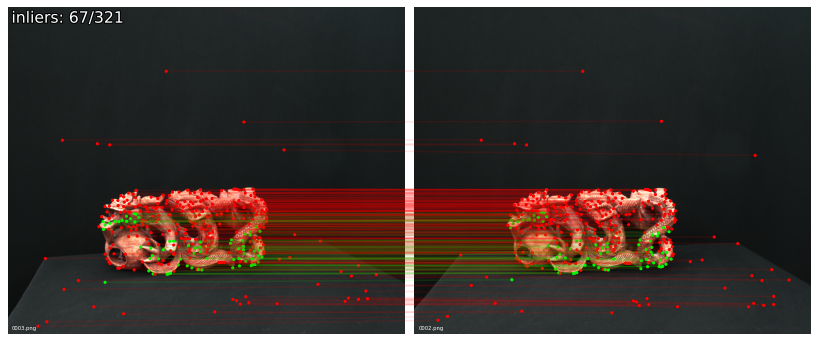

In [18]:
print(f'found {sum(ret["inliers"])}/{len(ret["inliers"])} inlier correspondences.')

visualization.visualize_loc_from_log(images_all, 
                         query, 
                         log, 
                         model, 
                         top_k_db=2)

# Visualization of first query

In [19]:
result_dir = exp_loc / 'result'
result_dir.mkdir(parents=True, exist_ok=True)

fig3d = init_figure()

pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
plot_camera_colmap(fig3d, pose, pinhole_camera, color='rgba(128,128,255,0.5)', 
                   name=query, legendgroup="refined", size=2)
args = dict(max_reproj_error=3.0, min_track_length=2, cs=1)
plot_reconstruction(fig3d, model, color='rgba(0, 255, 0, 0.5)', name="model", **args)
fig3d.show()
fig3d.write_html(result_dir / "dragon_one_query_localizer.html")

# Query Localization (all queries)

Находим позу для всех query изображений при помощи функции **pose_cluster**. Под капотом, QueryLocalizer извлекает dense features для query изображения и прогоняет QKA (query keypoint adjustment) и QBA (query pose adjustment). Для нахождения позы в среднем на одну картинку размером 2368х1952 уходит 3 минуты.

In [20]:
result_dict = {}
extra_dict = {}

for k, query in enumerate(sorted(queries)):
    print(f'Current query image --> {query}')

    ret, log = pose_from_cluster(localizer, 
                                 query, 
                                 pinhole_camera, 
                                 ref_ids, 
                                 features_query, 
                                 matches_query, 
                                 image_path=images_all / query)    
    
    print("ret --> ", ret['qvec'], ret['tvec'], ret['camera'])

    image_id = int(Path(query).stem) + 1
    
    result_dict[image_id] = Image(
                id=image_id, 
                qvec=ret['qvec'], 
                tvec=ret['tvec'],
                camera_id=cam_info.id, 
                name=query,
                xys= np.array([]), 
                point3D_ids= np.array([]),
    )
    
    extra_dict.update({
        'id': int(Path(query).stem) + 1,
        'qvec': ret['qvec'],
        'tvec': ret['tvec'],
        'camera': ret['camera'],
    })
    

[2022/10/15 02:51:40 pixsfm INFO] Start features exctraction.


Current query image --> 0003.png
None True


[2022/10/15 02:51:41 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:41 pixsfm INFO] Run QKA


[2022/10/15 02:51:41 pixsfm INFO] QKA Time: 0.100659s, cost change: 0.0462537 --> 0.0283531


[2022/10/15 02:51:41 pixsfm INFO] Running PnP with 342 correspondences.
[2022/10/15 02:51:41 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:41 pixsfm INFO]  Run QBA


[2022/10/15 02:51:41 pixsfm INFO] QBA Time: 0.200539s, cost change: 0.0261753 --> 0.0258429


[2022/10/15 02:51:41 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:41 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88383096 -0.35980417 -0.27415773  0.11925325] [37.83969879 18.7266576  24.46062399] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0004.png
None True


[2022/10/15 02:51:42 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:42 pixsfm INFO] Run QKA


[2022/10/15 02:51:42 pixsfm INFO] QKA Time: 0.071172s, cost change: 0.0508341 --> 0.0332269


[2022/10/15 02:51:42 pixsfm INFO] Running PnP with 321 correspondences.
[2022/10/15 02:51:42 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:42 pixsfm INFO]  Run QBA


[2022/10/15 02:51:42 pixsfm INFO] QBA Time: 0.195656s, cost change: 0.0259798 --> 0.0252364


[2022/10/15 02:51:42 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:42 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88086259 -0.37129486 -0.27575739  0.10089145] [36.53924294 19.70397007 27.66791719] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0005.png
None True


[2022/10/15 02:51:43 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:43 pixsfm INFO] Run QKA


[2022/10/15 02:51:43 pixsfm INFO] QKA Time: 0.103071s, cost change: 0.0522458 --> 0.0363181


[2022/10/15 02:51:43 pixsfm INFO] Running PnP with 294 correspondences.
[2022/10/15 02:51:43 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:43 pixsfm INFO]  Run QBA


[2022/10/15 02:51:43 pixsfm INFO] QBA Time: 0.192632s, cost change: 0.0259099 --> 0.0258411


[2022/10/15 02:51:43 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:43 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87872781 -0.34751457 -0.30776407  0.11114109] [40.378764   20.39077828 25.41562467] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0006.png
None True


[2022/10/15 02:51:44 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:44 pixsfm INFO] Run QKA


[2022/10/15 02:51:44 pixsfm INFO] QKA Time: 0.0718088s, cost change: 0.0545583 --> 0.0398811


[2022/10/15 02:51:44 pixsfm INFO] Running PnP with 284 correspondences.
[2022/10/15 02:51:44 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:44 pixsfm INFO]  Run QBA


[2022/10/15 02:51:44 pixsfm INFO] QBA Time: 0.194183s, cost change: 0.0260163 --> 0.0259369


[2022/10/15 02:51:44 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:44 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87042018 -0.34804944 -0.33057845  0.10930772] [42.17519933 20.35587397 26.77019826] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0007.png
None True


[2022/10/15 02:51:45 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:45 pixsfm INFO] Run QKA


[2022/10/15 02:51:45 pixsfm INFO] QKA Time: 0.0795319s, cost change: 0.0560529 --> 0.042145


[2022/10/15 02:51:45 pixsfm INFO] Running PnP with 269 correspondences.
[2022/10/15 02:51:45 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:45 pixsfm INFO]  Run QBA


[2022/10/15 02:51:45 pixsfm INFO] QBA Time: 0.187499s, cost change: 0.0261996 --> 0.0259926


[2022/10/15 02:51:45 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:45 pixsfm INFO] Start features exctraction.


ret -->  [ 0.86905139 -0.33017854 -0.34987923  0.1153964 ] [44.51984105 22.88654794 26.6885748 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0008.png
None True


[2022/10/15 02:51:46 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:46 pixsfm INFO] Run QKA


[2022/10/15 02:51:46 pixsfm INFO] QKA Time: 0.105364s, cost change: 0.0584866 --> 0.0448896


[2022/10/15 02:51:46 pixsfm INFO] Running PnP with 257 correspondences.
[2022/10/15 02:51:46 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:46 pixsfm INFO]  Run QBA


[2022/10/15 02:51:46 pixsfm INFO] QBA Time: 0.193475s, cost change: 0.0261496 --> 0.0257897


[2022/10/15 02:51:46 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:46 pixsfm INFO] Start features exctraction.


ret -->  [ 0.85681336 -0.33267639 -0.37624087  0.11679084] [46.68578556 22.73311037 28.66263914] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0009.png
None True


[2022/10/15 02:51:47 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:47 pixsfm INFO] Run QKA


[2022/10/15 02:51:47 pixsfm INFO] QKA Time: 0.148237s, cost change: 0.059837 --> 0.0478716


[2022/10/15 02:51:47 pixsfm INFO] Running PnP with 229 correspondences.
[2022/10/15 02:51:47 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:47 pixsfm INFO]  Run QBA


[2022/10/15 02:51:47 pixsfm INFO] QBA Time: 0.206543s, cost change: 0.0268425 --> 0.0265907


[2022/10/15 02:51:47 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:47 pixsfm INFO] Start features exctraction.


ret -->  [ 0.85106813 -0.31782002 -0.40003124  0.12103087] [49.04838436 23.69067781 28.45536442] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0010.png
None True


[2022/10/15 02:51:47 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:47 pixsfm INFO] Run QKA


[2022/10/15 02:51:48 pixsfm INFO] QKA Time: 0.0824542s, cost change: 0.0605656 --> 0.0489493


[2022/10/15 02:51:48 pixsfm INFO] Running PnP with 219 correspondences.
[2022/10/15 02:51:48 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:48 pixsfm INFO]  Run QBA


[2022/10/15 02:51:48 pixsfm INFO] QBA Time: 0.190891s, cost change: 0.026746 --> 0.026613


[2022/10/15 02:51:48 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:48 pixsfm INFO] Start features exctraction.


ret -->  [ 0.84390677 -0.28306328 -0.43393366  0.13927715] [53.01902249 25.93490929 26.29336522] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0011.png
None True


[2022/10/15 02:51:48 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:48 pixsfm INFO] Run QKA


[2022/10/15 02:51:48 pixsfm INFO] QKA Time: 0.103872s, cost change: 0.0611304 --> 0.0499972


[2022/10/15 02:51:48 pixsfm INFO] Running PnP with 202 correspondences.
[2022/10/15 02:51:48 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:48 pixsfm INFO]  Run QBA


[2022/10/15 02:51:49 pixsfm INFO] QBA Time: 0.187489s, cost change: 0.0267989 --> 0.0265736


[2022/10/15 02:51:49 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:49 pixsfm INFO] Start features exctraction.


ret -->  [ 0.83306048 -0.27479568 -0.4577098   0.14491139] [55.04772903 27.406549   27.85153281] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0012.png
None True


[2022/10/15 02:51:49 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:49 pixsfm INFO] Run QKA


[2022/10/15 02:51:49 pixsfm INFO] QKA Time: 0.082274s, cost change: 0.0629198 --> 0.0524463


[2022/10/15 02:51:49 pixsfm INFO] Running PnP with 190 correspondences.
[2022/10/15 02:51:49 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:49 pixsfm INFO]  Run QBA


[2022/10/15 02:51:50 pixsfm INFO] QBA Time: 0.161557s, cost change: 0.0267461 --> 0.0265317


[2022/10/15 02:51:50 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:50 pixsfm INFO] Start features exctraction.


ret -->  [ 0.81765567 -0.26311914 -0.49681979  0.12400658] [57.02865938 28.9376645  31.85592862] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0013.png
None True


[2022/10/15 02:51:50 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:50 pixsfm INFO] Run QKA


[2022/10/15 02:51:50 pixsfm INFO] QKA Time: 0.118157s, cost change: 0.0615748 --> 0.0510708


[2022/10/15 02:51:50 pixsfm INFO] Running PnP with 221 correspondences.
[2022/10/15 02:51:50 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:50 pixsfm INFO]  Run QBA


[2022/10/15 02:51:51 pixsfm INFO] QBA Time: 0.190601s, cost change: 0.0265705 --> 0.0264879


[2022/10/15 02:51:51 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:51 pixsfm INFO] Start features exctraction.


ret -->  [ 0.83993365 -0.25583388 -0.46208182  0.12466305] [54.77909432 28.8775028  27.5471883 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0014.png
None True


[2022/10/15 02:51:51 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:51 pixsfm INFO] Run QKA


[2022/10/15 02:51:51 pixsfm INFO] QKA Time: 0.0676441s, cost change: 0.0615756 --> 0.0505114


[2022/10/15 02:51:51 pixsfm INFO] Running PnP with 229 correspondences.
[2022/10/15 02:51:51 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:51 pixsfm INFO]  Run QBA


[2022/10/15 02:51:51 pixsfm INFO] QBA Time: 0.187333s, cost change: 0.0265677 --> 0.0264941


[2022/10/15 02:51:51 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:51 pixsfm INFO] Start features exctraction.


ret -->  [ 0.84277438 -0.29116203 -0.43912373  0.11011983] [52.16119085 27.77647617 31.07185464] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0015.png
None True


[2022/10/15 02:51:52 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:52 pixsfm INFO] Run QKA


[2022/10/15 02:51:52 pixsfm INFO] QKA Time: 0.100774s, cost change: 0.0597987 --> 0.0482592


[2022/10/15 02:51:52 pixsfm INFO] Running PnP with 248 correspondences.
[2022/10/15 02:51:52 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:52 pixsfm INFO]  Run QBA


[2022/10/15 02:51:52 pixsfm INFO] QBA Time: 0.175646s, cost change: 0.0261753 --> 0.0261038


[2022/10/15 02:51:52 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:52 pixsfm INFO] Start features exctraction.


ret -->  [ 0.86610693 -0.2838702  -0.39710823  0.10761762] [48.61219601 26.84562257 25.93486636] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0016.png
None True


[2022/10/15 02:51:53 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:53 pixsfm INFO] Run QKA


[2022/10/15 02:51:53 pixsfm INFO] QKA Time: 0.0850539s, cost change: 0.0587891 --> 0.0455354


[2022/10/15 02:51:53 pixsfm INFO] Running PnP with 248 correspondences.
[2022/10/15 02:51:53 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:53 pixsfm INFO]  Run QBA


[2022/10/15 02:51:53 pixsfm INFO] QBA Time: 0.201439s, cost change: 0.0260983 --> 0.0259737


[2022/10/15 02:51:53 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:53 pixsfm INFO] Start features exctraction.


ret -->  [ 0.86923249 -0.30237884 -0.3765876   0.10575297] [46.60245384 24.50918483 25.84390169] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0017.png
None True


[2022/10/15 02:51:54 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:54 pixsfm INFO] Run QKA


[2022/10/15 02:51:54 pixsfm INFO] QKA Time: 0.08529s, cost change: 0.0574186 --> 0.0431559


[2022/10/15 02:51:54 pixsfm INFO] Running PnP with 273 correspondences.
[2022/10/15 02:51:54 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:54 pixsfm INFO]  Run QBA


[2022/10/15 02:51:54 pixsfm INFO] QBA Time: 0.199561s, cost change: 0.0263317 --> 0.0261606


[2022/10/15 02:51:54 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:54 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87444134 -0.31939754 -0.35113303  0.10021548] [43.89994714 23.26780792 26.20399451] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0018.png
None True


[2022/10/15 02:51:55 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:55 pixsfm INFO] Run QKA


[2022/10/15 02:51:55 pixsfm INFO] QKA Time: 0.0835869s, cost change: 0.0552966 --> 0.0405448


[2022/10/15 02:51:55 pixsfm INFO] Running PnP with 289 correspondences.
[2022/10/15 02:51:55 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:55 pixsfm INFO]  Run QBA


[2022/10/15 02:51:55 pixsfm INFO] QBA Time: 0.186286s, cost change: 0.0261587 --> 0.0259361


[2022/10/15 02:51:55 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:55 pixsfm INFO] Start features exctraction.


ret -->  [ 0.875916   -0.3363047  -0.33084729  0.10104643] [42.00533938 21.7629915  26.69088119] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0019.png
None True


[2022/10/15 02:51:56 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:56 pixsfm INFO] Run QKA


[2022/10/15 02:51:56 pixsfm INFO] QKA Time: 0.061033s, cost change: 0.0533185 --> 0.0377645


[2022/10/15 02:51:56 pixsfm INFO] Running PnP with 306 correspondences.
[2022/10/15 02:51:56 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:56 pixsfm INFO]  Run QBA


[2022/10/15 02:51:56 pixsfm INFO] QBA Time: 0.196139s, cost change: 0.0259762 --> 0.0256859


[2022/10/15 02:51:56 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:56 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89528771 -0.32791494 -0.28765206  0.09048753] [37.49838913 23.20247028 24.1390357 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0020.png
None True


[2022/10/15 02:51:57 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:57 pixsfm INFO] Run QKA


[2022/10/15 02:51:57 pixsfm INFO] QKA Time: 0.087853s, cost change: 0.0500497 --> 0.0328583


[2022/10/15 02:51:57 pixsfm INFO] Running PnP with 316 correspondences.
[2022/10/15 02:51:57 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:57 pixsfm INFO]  Run QBA


[2022/10/15 02:51:57 pixsfm INFO] QBA Time: 0.2017s, cost change: 0.0258752 --> 0.0256388


[2022/10/15 02:51:57 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:57 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89761323 -0.33878339 -0.26654183  0.09204213] [35.46687493 21.97430007 23.96115754] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0021.png
None True


[2022/10/15 02:51:58 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:58 pixsfm INFO] Run QKA


[2022/10/15 02:51:58 pixsfm INFO] QKA Time: 0.083569s, cost change: 0.0486012 --> 0.030159


[2022/10/15 02:51:58 pixsfm INFO] Running PnP with 341 correspondences.
[2022/10/15 02:51:58 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:58 pixsfm INFO]  Run QBA


[2022/10/15 02:51:58 pixsfm INFO] QBA Time: 0.161895s, cost change: 0.0252247 --> 0.0251691


[2022/10/15 02:51:58 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:58 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95037159 -0.17078871 -0.21642478  0.14417135] [32.88248769 34.25590983  2.38820814] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0022.png
None True


[2022/10/15 02:51:59 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:59 pixsfm INFO] Run QKA


[2022/10/15 02:51:59 pixsfm INFO] QKA Time: 0.0918772s, cost change: 0.0450524 --> 0.0261578


[2022/10/15 02:51:59 pixsfm INFO] Running PnP with 359 correspondences.
[2022/10/15 02:51:59 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:51:59 pixsfm INFO]  Run QBA


[2022/10/15 02:51:59 pixsfm INFO] QBA Time: 0.137596s, cost change: 0.0252272 --> 0.0250394


[2022/10/15 02:51:59 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:51:59 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95243946 -0.17968137 -0.19788992  0.14633272] [31.08939951 33.61054073  2.57170261] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0023.png
None True


[2022/10/15 02:51:59 pixsfm INFO] Get references for this query.
[2022/10/15 02:51:59 pixsfm INFO] Run QKA


[2022/10/15 02:52:00 pixsfm INFO] QKA Time: 0.0946121s, cost change: 0.045358 --> 0.0264975


[2022/10/15 02:52:00 pixsfm INFO] Running PnP with 359 correspondences.
[2022/10/15 02:52:00 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:00 pixsfm INFO]  Run QBA


[2022/10/15 02:52:00 pixsfm INFO] QBA Time: 0.160337s, cost change: 0.0259705 --> 0.0258796


[2022/10/15 02:52:00 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:00 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90671673 -0.35747174  0.20403045 -0.09192553] [-28.23883698  14.75484495  19.38704856] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0024.png
None True


[2022/10/15 02:52:00 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:00 pixsfm INFO] Run QKA


[2022/10/15 02:52:00 pixsfm INFO] QKA Time: 0.0772099s, cost change: 0.0495072 --> 0.0326137


[2022/10/15 02:52:00 pixsfm INFO] Running PnP with 336 correspondences.
[2022/10/15 02:52:01 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:01 pixsfm INFO]  Run QBA


[2022/10/15 02:52:01 pixsfm INFO] QBA Time: 0.120583s, cost change: 0.0263124 --> 0.0261622


[2022/10/15 02:52:01 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:01 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89983898 -0.3436812   0.24790058 -0.10352941] [-33.44944267  14.32933752  18.18114483] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0025.png
None True


[2022/10/15 02:52:01 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:01 pixsfm INFO] Run QKA


[2022/10/15 02:52:01 pixsfm INFO] QKA Time: 0.0678411s, cost change: 0.0490867 --> 0.0307093


[2022/10/15 02:52:01 pixsfm INFO] Running PnP with 346 correspondences.
[2022/10/15 02:52:01 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:01 pixsfm INFO]  Run QBA


[2022/10/15 02:52:02 pixsfm INFO] QBA Time: 0.183012s, cost change: 0.0261202 --> 0.0259705


[2022/10/15 02:52:02 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:02 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89815389 -0.34024502 -0.24528035  0.1318729 ] [36.2272277  20.41662727 21.75894121] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0026.png
None True


[2022/10/15 02:52:02 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:02 pixsfm INFO] Run QKA


[2022/10/15 02:52:02 pixsfm INFO] QKA Time: 0.071136s, cost change: 0.0485803 --> 0.0325681


[2022/10/15 02:52:02 pixsfm INFO] Running PnP with 333 correspondences.
[2022/10/15 02:52:02 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:02 pixsfm INFO]  Run QBA


[2022/10/15 02:52:03 pixsfm INFO] QBA Time: 0.14549s, cost change: 0.0259003 --> 0.0257793


[2022/10/15 02:52:03 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:03 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90230103 -0.35435314 -0.22793592  0.0912794 ] [31.64973692 20.9289778  24.8499332 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0027.png
None True


[2022/10/15 02:52:03 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:03 pixsfm INFO] Run QKA


[2022/10/15 02:52:03 pixsfm INFO] QKA Time: 0.0853961s, cost change: 0.0511621 --> 0.0354665


[2022/10/15 02:52:03 pixsfm INFO] Running PnP with 328 correspondences.
[2022/10/15 02:52:03 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:03 pixsfm INFO]  Run QBA


[2022/10/15 02:52:03 pixsfm INFO] QBA Time: 0.176123s, cost change: 0.025686 --> 0.0255682


[2022/10/15 02:52:03 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:03 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90102105 -0.34622184 -0.24783089  0.08289362] [33.02249486 21.66981361 24.93339492] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0028.png
None True


[2022/10/15 02:52:04 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:04 pixsfm INFO] Run QKA


[2022/10/15 02:52:04 pixsfm INFO] QKA Time: 0.109539s, cost change: 0.0529173 --> 0.0370028


[2022/10/15 02:52:04 pixsfm INFO] Running PnP with 309 correspondences.
[2022/10/15 02:52:04 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:04 pixsfm INFO]  Run QBA


[2022/10/15 02:52:04 pixsfm INFO] QBA Time: 0.180166s, cost change: 0.0263253 --> 0.0260479


[2022/10/15 02:52:04 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:04 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89778812 -0.30350094 -0.30093937  0.10629753] [40.17384124 23.54615391 21.18767438] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0029.png
None True


[2022/10/15 02:52:05 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:05 pixsfm INFO] Run QKA


[2022/10/15 02:52:05 pixsfm INFO] QKA Time: 0.0922551s, cost change: 0.0530983 --> 0.0406133


[2022/10/15 02:52:05 pixsfm INFO] Running PnP with 294 correspondences.
[2022/10/15 02:52:05 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:05 pixsfm INFO]  Run QBA


[2022/10/15 02:52:05 pixsfm INFO] QBA Time: 0.186825s, cost change: 0.0263108 --> 0.025397


[2022/10/15 02:52:05 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:05 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90540369 -0.30141251 -0.28898635  0.07669129] [37.15493149 26.18947101 22.84983736] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0030.png
None True


[2022/10/15 02:52:06 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:06 pixsfm INFO] Run QKA


[2022/10/15 02:52:06 pixsfm INFO] QKA Time: 0.12081s, cost change: 0.0568871 --> 0.0424818


[2022/10/15 02:52:06 pixsfm INFO] Running PnP with 305 correspondences.
[2022/10/15 02:52:06 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:06 pixsfm INFO]  Run QBA


[2022/10/15 02:52:06 pixsfm INFO] QBA Time: 0.206322s, cost change: 0.026488 --> 0.0261962


[2022/10/15 02:52:06 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:06 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89091253 -0.30027176 -0.32990478  0.08529114] [41.47008631 24.89550387 23.81922289] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0031.png
None True


[2022/10/15 02:52:07 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:07 pixsfm INFO] Run QKA


[2022/10/15 02:52:07 pixsfm INFO] QKA Time: 0.120028s, cost change: 0.0589314 --> 0.0462498


[2022/10/15 02:52:07 pixsfm INFO] Running PnP with 270 correspondences.
[2022/10/15 02:52:07 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:07 pixsfm INFO]  Run QBA


[2022/10/15 02:52:07 pixsfm INFO] QBA Time: 0.19899s, cost change: 0.02651 --> 0.0262993


[2022/10/15 02:52:07 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:07 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88626563 -0.27676978 -0.35954282  0.09306284] [44.88956335 26.4209554  22.8015657 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0032.png
None True


[2022/10/15 02:52:08 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:08 pixsfm INFO] Run QKA


[2022/10/15 02:52:08 pixsfm INFO] QKA Time: 0.079165s, cost change: 0.059263 --> 0.0462684


[2022/10/15 02:52:08 pixsfm INFO] Running PnP with 244 correspondences.
[2022/10/15 02:52:08 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:08 pixsfm INFO]  Run QBA


[2022/10/15 02:52:08 pixsfm INFO] QBA Time: 0.191075s, cost change: 0.0263415 --> 0.026165


[2022/10/15 02:52:08 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:08 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87875431 -0.26745035 -0.38409422  0.09344946] [47.16170701 27.91168187 24.11874514] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0033.png
None True


[2022/10/15 02:52:09 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:09 pixsfm INFO] Run QKA


[2022/10/15 02:52:09 pixsfm INFO] QKA Time: 0.0863612s, cost change: 0.0607549 --> 0.0486202


[2022/10/15 02:52:09 pixsfm INFO] Running PnP with 249 correspondences.
[2022/10/15 02:52:09 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:09 pixsfm INFO]  Run QBA


[2022/10/15 02:52:09 pixsfm INFO] QBA Time: 0.195852s, cost change: 0.0266228 --> 0.0266156


[2022/10/15 02:52:09 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:09 pixsfm INFO] Start features exctraction.


ret -->  [ 0.86940936 -0.25478676 -0.41319973  0.09207092] [49.6817184  28.96434891 25.06312055] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0034.png
None True


[2022/10/15 02:52:10 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:10 pixsfm INFO] Run QKA


[2022/10/15 02:52:10 pixsfm INFO] QKA Time: 0.102482s, cost change: 0.0621631 --> 0.0504664


[2022/10/15 02:52:10 pixsfm INFO] Running PnP with 220 correspondences.
[2022/10/15 02:52:10 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:10 pixsfm INFO]  Run QBA


[2022/10/15 02:52:10 pixsfm INFO] QBA Time: 0.187822s, cost change: 0.0267228 --> 0.0266994


[2022/10/15 02:52:10 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:10 pixsfm INFO] Start features exctraction.


ret -->  [ 0.8557104  -0.24713643 -0.44424135  0.09660709] [52.44068359 29.63917066 26.835302  ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0035.png
None True


[2022/10/15 02:52:11 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:11 pixsfm INFO] Run QKA


[2022/10/15 02:52:11 pixsfm INFO] QKA Time: 0.09741s, cost change: 0.063107 --> 0.0522854


[2022/10/15 02:52:11 pixsfm INFO] Running PnP with 203 correspondences.
[2022/10/15 02:52:11 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:11 pixsfm INFO]  Run QBA


[2022/10/15 02:52:11 pixsfm INFO] QBA Time: 0.118412s, cost change: 0.0264382 --> 0.0263926


[2022/10/15 02:52:11 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:11 pixsfm INFO] Start features exctraction.


ret -->  [ 0.83718984 -0.23755869 -0.48175399  0.10291808] [55.60453666 29.96891688 28.63863792] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0036.png
None True


[2022/10/15 02:52:11 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:11 pixsfm INFO] Run QKA


[2022/10/15 02:52:12 pixsfm INFO] QKA Time: 0.106697s, cost change: 0.0651925 --> 0.0543906


[2022/10/15 02:52:12 pixsfm INFO] Running PnP with 184 correspondences.
[2022/10/15 02:52:12 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:12 pixsfm INFO]  Run QBA


[2022/10/15 02:52:12 pixsfm INFO] QBA Time: 0.147262s, cost change: 0.0267347 --> 0.0265892


[2022/10/15 02:52:12 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.84980283 -0.19405994 -0.48330192  0.08121056] [55.59121959 35.18277283 27.91355368] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0037.png


[2022/10/15 02:52:12 pixsfm INFO] Start features exctraction.


None True


[2022/10/15 02:52:12 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:12 pixsfm INFO] Run QKA


[2022/10/15 02:52:12 pixsfm INFO] QKA Time: 0.0781178s, cost change: 0.0632297 --> 0.0527567


[2022/10/15 02:52:12 pixsfm INFO] Running PnP with 214 correspondences.
[2022/10/15 02:52:12 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:12 pixsfm INFO]  Run QBA


[2022/10/15 02:52:13 pixsfm INFO] QBA Time: 0.182212s, cost change: 0.0267598 --> 0.0266893


[2022/10/15 02:52:13 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:13 pixsfm INFO] Start features exctraction.


ret -->  [ 0.85266139 -0.23144083 -0.46347534  0.06778124] [53.16008839 32.5767317  30.19353923] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0038.png
None True


[2022/10/15 02:52:13 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:13 pixsfm INFO] Run QKA


[2022/10/15 02:52:13 pixsfm INFO] QKA Time: 0.0983629s, cost change: 0.0614406 --> 0.051256


[2022/10/15 02:52:13 pixsfm INFO] Running PnP with 239 correspondences.
[2022/10/15 02:52:13 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:13 pixsfm INFO]  Run QBA


[2022/10/15 02:52:14 pixsfm INFO] QBA Time: 0.193245s, cost change: 0.0270142 --> 0.0269324


[2022/10/15 02:52:14 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:14 pixsfm INFO] Start features exctraction.


ret -->  [ 0.86643778 -0.24385447 -0.4313641   0.06120122] [50.09177737 29.77894951 27.13457072] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0039.png
None True


[2022/10/15 02:52:14 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:14 pixsfm INFO] Run QKA


[2022/10/15 02:52:14 pixsfm INFO] QKA Time: 0.104683s, cost change: 0.0611348 --> 0.0499591


[2022/10/15 02:52:14 pixsfm INFO] Running PnP with 242 correspondences.
[2022/10/15 02:52:14 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:14 pixsfm INFO]  Run QBA


[2022/10/15 02:52:15 pixsfm INFO] QBA Time: 0.199375s, cost change: 0.026442 --> 0.026348


[2022/10/15 02:52:15 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:15 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88570211 -0.23368107 -0.39482936  0.0709557 ] [47.50970091 31.22921676 23.34521146] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0040.png
None True


[2022/10/15 02:52:15 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:15 pixsfm INFO] Run QKA


[2022/10/15 02:52:15 pixsfm INFO] QKA Time: 0.12624s, cost change: 0.059954 --> 0.0478729


[2022/10/15 02:52:15 pixsfm INFO] Running PnP with 270 correspondences.
[2022/10/15 02:52:15 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:15 pixsfm INFO]  Run QBA


[2022/10/15 02:52:16 pixsfm INFO] QBA Time: 0.218261s, cost change: 0.0262661 --> 0.0261121


[2022/10/15 02:52:16 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:16 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89324836 -0.24812236 -0.36774311  0.07285374] [45.01529286 29.52942021 22.2473827 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0041.png
None True


[2022/10/15 02:52:16 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:16 pixsfm INFO] Run QKA


[2022/10/15 02:52:16 pixsfm INFO] QKA Time: 0.101285s, cost change: 0.0579456 --> 0.0459363


[2022/10/15 02:52:16 pixsfm INFO] Running PnP with 270 correspondences.
[2022/10/15 02:52:16 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:16 pixsfm INFO]  Run QBA


[2022/10/15 02:52:16 pixsfm INFO] QBA Time: 0.200397s, cost change: 0.0266876 --> 0.0262427


[2022/10/15 02:52:16 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:16 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89471131 -0.26805772 -0.34928052  0.07509885] [43.20364948 27.21695392 22.41896884] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0042.png
None True


[2022/10/15 02:52:17 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:17 pixsfm INFO] Run QKA


[2022/10/15 02:52:17 pixsfm INFO] QKA Time: 0.0874882s, cost change: 0.0564638 --> 0.0425181


[2022/10/15 02:52:17 pixsfm INFO] Running PnP with 275 correspondences.
[2022/10/15 02:52:17 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:17 pixsfm INFO]  Run QBA


[2022/10/15 02:52:17 pixsfm INFO] QBA Time: 0.181562s, cost change: 0.0262649 --> 0.0258533


[2022/10/15 02:52:17 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:17 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9145875  -0.26602802 -0.29792357  0.06324823] [37.73437345 29.57462052 20.92108401] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0043.png
None True


[2022/10/15 02:52:18 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:18 pixsfm INFO] Run QKA


[2022/10/15 02:52:18 pixsfm INFO] QKA Time: 0.0949728s, cost change: 0.0545242 --> 0.0395345


[2022/10/15 02:52:18 pixsfm INFO] Running PnP with 292 correspondences.
[2022/10/15 02:52:18 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:18 pixsfm INFO]  Run QBA


[2022/10/15 02:52:18 pixsfm INFO] QBA Time: 0.184616s, cost change: 0.025956 --> 0.0258809


[2022/10/15 02:52:18 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:18 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91224173 -0.25482259 -0.30349923  0.10377235] [40.85724162 28.5788806  17.69405789] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0044.png
None True


[2022/10/15 02:52:19 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:19 pixsfm INFO] Run QKA


[2022/10/15 02:52:19 pixsfm INFO] QKA Time: 0.119012s, cost change: 0.0538938 --> 0.0386989


[2022/10/15 02:52:19 pixsfm INFO] Running PnP with 306 correspondences.
[2022/10/15 02:52:19 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:19 pixsfm INFO]  Run QBA


[2022/10/15 02:52:19 pixsfm INFO] QBA Time: 0.171018s, cost change: 0.0261355 --> 0.0260314


[2022/10/15 02:52:19 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:19 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90961885 -0.32930967 -0.24493325  0.06447007] [31.74267428 23.0480905  23.90137543] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0045.png
None True


[2022/10/15 02:52:20 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:20 pixsfm INFO] Run QKA


[2022/10/15 02:52:20 pixsfm INFO] QKA Time: 0.133537s, cost change: 0.052239 --> 0.0363719


[2022/10/15 02:52:20 pixsfm INFO] Running PnP with 314 correspondences.
[2022/10/15 02:52:20 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:20 pixsfm INFO]  Run QBA


[2022/10/15 02:52:20 pixsfm INFO] QBA Time: 0.156738s, cost change: 0.0260528 --> 0.025856


[2022/10/15 02:52:20 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:20 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92794622 -0.31067602 -0.1948724   0.06649035] [27.06077658 27.26668068 22.12017511] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0046.png
None True


[2022/10/15 02:52:21 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:21 pixsfm INFO] Run QKA


[2022/10/15 02:52:21 pixsfm INFO] QKA Time: 0.061249s, cost change: 0.0523195 --> 0.0366205


[2022/10/15 02:52:21 pixsfm INFO] Running PnP with 329 correspondences.
[2022/10/15 02:52:21 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:21 pixsfm INFO]  Run QBA


[2022/10/15 02:52:21 pixsfm INFO] QBA Time: 0.183245s, cost change: 0.0263684 --> 0.0261328


[2022/10/15 02:52:21 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:21 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91891144 -0.26913605 -0.25243846  0.13943589] [37.87885168 27.51164699 15.87456041] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0047.png
None True


[2022/10/15 02:52:22 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:22 pixsfm INFO] Run QKA


[2022/10/15 02:52:22 pixsfm INFO] QKA Time: 0.062099s, cost change: 0.0503564 --> 0.0354131


[2022/10/15 02:52:22 pixsfm INFO] Running PnP with 312 correspondences.
[2022/10/15 02:52:22 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:22 pixsfm INFO]  Run QBA


[2022/10/15 02:52:22 pixsfm INFO] QBA Time: 0.141338s, cost change: 0.0262787 --> 0.0261802


[2022/10/15 02:52:22 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:22 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92280639 -0.31754627  0.1986522  -0.09016674] [-27.48022633  18.4042283   16.12027447] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0048.png
None True


[2022/10/15 02:52:23 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:23 pixsfm INFO] Run QKA


[2022/10/15 02:52:23 pixsfm INFO] QKA Time: 0.136486s, cost change: 0.0539522 --> 0.0386546


[2022/10/15 02:52:23 pixsfm INFO] Running PnP with 299 correspondences.
[2022/10/15 02:52:23 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:23 pixsfm INFO]  Run QBA


[2022/10/15 02:52:23 pixsfm INFO] QBA Time: 0.161121s, cost change: 0.0268235 --> 0.0266058


[2022/10/15 02:52:23 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:23 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94344509 -0.22203754  0.21224972 -0.12474272] [-30.64177579  26.89881535   6.83938058] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0049.png
None True


[2022/10/15 02:52:24 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:24 pixsfm INFO] Run QKA


[2022/10/15 02:52:24 pixsfm INFO] QKA Time: 0.0929868s, cost change: 0.0527926 --> 0.0383548


[2022/10/15 02:52:24 pixsfm INFO] Running PnP with 312 correspondences.
[2022/10/15 02:52:24 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:24 pixsfm INFO]  Run QBA


[2022/10/15 02:52:24 pixsfm INFO] QBA Time: 0.178452s, cost change: 0.0265493 --> 0.026486


[2022/10/15 02:52:24 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:24 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93753222 -0.29717858  0.16091254 -0.08261592] [-22.90847278  21.646445    14.69651807] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0050.png
None True


[2022/10/15 02:52:25 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:25 pixsfm INFO] Run QKA


[2022/10/15 02:52:25 pixsfm INFO] QKA Time: 0.0736589s, cost change: 0.0542307 --> 0.0395284


[2022/10/15 02:52:25 pixsfm INFO] Running PnP with 290 correspondences.
[2022/10/15 02:52:25 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:25 pixsfm INFO]  Run QBA


[2022/10/15 02:52:25 pixsfm INFO] QBA Time: 0.128606s, cost change: 0.0266351 --> 0.0262579


[2022/10/15 02:52:25 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:25 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92329459 -0.25418763 -0.25775966  0.12835777] [37.80261293 28.800562   15.49458084] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0051.png
None True


[2022/10/15 02:52:25 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:25 pixsfm INFO] Run QKA


[2022/10/15 02:52:26 pixsfm INFO] QKA Time: 0.14771s, cost change: 0.0556612 --> 0.0404832


[2022/10/15 02:52:26 pixsfm INFO] Running PnP with 298 correspondences.
[2022/10/15 02:52:26 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:26 pixsfm INFO]  Run QBA


[2022/10/15 02:52:26 pixsfm INFO] QBA Time: 0.130786s, cost change: 0.0258721 --> 0.0257863


[2022/10/15 02:52:26 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:26 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92286094 -0.3073042  -0.22542705  0.05544783] [29.57129989 27.14384797 23.41583626] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0052.png
None True


[2022/10/15 02:52:26 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:26 pixsfm INFO] Run QKA


[2022/10/15 02:52:26 pixsfm INFO] QKA Time: 0.087198s, cost change: 0.0566559 --> 0.0426347


[2022/10/15 02:52:26 pixsfm INFO] Running PnP with 278 correspondences.
[2022/10/15 02:52:27 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:27 pixsfm INFO]  Run QBA


[2022/10/15 02:52:27 pixsfm INFO] QBA Time: 0.158992s, cost change: 0.0264734 --> 0.0262567


[2022/10/15 02:52:27 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:27 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93979372 -0.24247803 -0.23374051  0.05794425] [30.85820215 31.42300994 16.20986616] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0053.png
None True


[2022/10/15 02:52:27 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:27 pixsfm INFO] Run QKA


[2022/10/15 02:52:27 pixsfm INFO] QKA Time: 0.0974848s, cost change: 0.058085 --> 0.0450653


[2022/10/15 02:52:27 pixsfm INFO] Running PnP with 274 correspondences.
[2022/10/15 02:52:27 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:27 pixsfm INFO]  Run QBA


[2022/10/15 02:52:28 pixsfm INFO] QBA Time: 0.189928s, cost change: 0.0265944 --> 0.0262635


[2022/10/15 02:52:28 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:28 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91976524 -0.23452786 -0.30690987  0.06953356] [39.43690012 29.61332592 16.86376882] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0054.png
None True


[2022/10/15 02:52:28 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:28 pixsfm INFO] Run QKA


[2022/10/15 02:52:28 pixsfm INFO] QKA Time: 0.107347s, cost change: 0.0581958 --> 0.0466845


[2022/10/15 02:52:28 pixsfm INFO] Running PnP with 285 correspondences.
[2022/10/15 02:52:28 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:28 pixsfm INFO]  Run QBA


[2022/10/15 02:52:29 pixsfm INFO] QBA Time: 0.194161s, cost change: 0.0264937 --> 0.0260505


[2022/10/15 02:52:29 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:29 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91255227 -0.23860353 -0.32820122  0.05099687] [40.34831114 30.72232479 20.09072772] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0055.png
None True


[2022/10/15 02:52:29 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:29 pixsfm INFO] Run QKA


[2022/10/15 02:52:29 pixsfm INFO] QKA Time: 0.180101s, cost change: 0.0603024 --> 0.049423


[2022/10/15 02:52:29 pixsfm INFO] Running PnP with 273 correspondences.
[2022/10/15 02:52:29 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:29 pixsfm INFO]  Run QBA


[2022/10/15 02:52:30 pixsfm INFO] QBA Time: 0.175899s, cost change: 0.0262942 --> 0.0262193


[2022/10/15 02:52:30 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:30 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90453248 -0.21783351 -0.36216378  0.05662997] [44.20445014 32.36180785 20.29290408] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0056.png
None True


[2022/10/15 02:52:30 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:30 pixsfm INFO] Run QKA


[2022/10/15 02:52:30 pixsfm INFO] QKA Time: 0.109684s, cost change: 0.061928 --> 0.0504505


[2022/10/15 02:52:30 pixsfm INFO] Running PnP with 253 correspondences.
[2022/10/15 02:52:30 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:30 pixsfm INFO]  Run QBA


[2022/10/15 02:52:31 pixsfm INFO] QBA Time: 0.19531s, cost change: 0.0267871 --> 0.026668


[2022/10/15 02:52:31 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:31 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89185834 -0.20907135 -0.39728156  0.05518367] [47.52061922 33.23676905 22.37635725] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0057.png
None True


[2022/10/15 02:52:31 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:31 pixsfm INFO] Run QKA


[2022/10/15 02:52:31 pixsfm INFO] QKA Time: 0.128544s, cost change: 0.0625405 --> 0.0528181


[2022/10/15 02:52:31 pixsfm INFO] Running PnP with 241 correspondences.
[2022/10/15 02:52:31 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:31 pixsfm INFO]  Run QBA


[2022/10/15 02:52:31 pixsfm INFO] QBA Time: 0.189962s, cost change: 0.0270091 --> 0.0268189


[2022/10/15 02:52:31 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:32 pixsfm INFO] Start features exctraction.


ret -->  [ 0.87740261 -0.20383583 -0.43126351  0.05125826] [50.35654709 33.62261537 24.87849038] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0058.png
None True


[2022/10/15 02:52:32 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:32 pixsfm INFO] Run QKA


[2022/10/15 02:52:32 pixsfm INFO] QKA Time: 0.0756741s, cost change: 0.06516 --> 0.0551832


[2022/10/15 02:52:32 pixsfm INFO] Running PnP with 220 correspondences.
[2022/10/15 02:52:32 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:32 pixsfm INFO]  Run QBA


[2022/10/15 02:52:32 pixsfm INFO] QBA Time: 0.200093s, cost change: 0.0269231 --> 0.0268891


[2022/10/15 02:52:32 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:32 pixsfm INFO] Start features exctraction.


ret -->  [ 0.86012944 -0.20629178 -0.46453215  0.04278943] [52.52166073 33.50600457 28.55900702] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0059.png
None True


[2022/10/15 02:52:33 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:33 pixsfm INFO] Run QKA


[2022/10/15 02:52:33 pixsfm INFO] QKA Time: 0.167582s, cost change: 0.0669636 --> 0.0577139


[2022/10/15 02:52:33 pixsfm INFO] Running PnP with 227 correspondences.
[2022/10/15 02:52:33 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:33 pixsfm INFO]  Run QBA


[2022/10/15 02:52:33 pixsfm INFO] QBA Time: 0.159849s, cost change: 0.0270991 --> 0.0270678


[2022/10/15 02:52:33 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:33 pixsfm INFO] Start features exctraction.


ret -->  [ 0.85705345 -0.15498363 -0.49096434  0.01983628] [54.74406239 37.24815865 28.28124063] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0060.png
None True


[2022/10/15 02:52:34 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:34 pixsfm INFO] Run QKA


[2022/10/15 02:52:34 pixsfm INFO] QKA Time: 0.137995s, cost change: 0.0658427 --> 0.0562935


[2022/10/15 02:52:34 pixsfm INFO] Running PnP with 220 correspondences.
[2022/10/15 02:52:34 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:34 pixsfm INFO]  Run QBA


[2022/10/15 02:52:34 pixsfm INFO] QBA Time: 0.162403s, cost change: 0.0271415 --> 0.0270766


[2022/10/15 02:52:34 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:34 pixsfm INFO] Start features exctraction.


ret -->  [ 0.86416602 -0.15946562 -0.4754145   0.0420579 ] [54.14478156 33.84114543 23.32529425] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0061.png
None True


[2022/10/15 02:52:35 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:35 pixsfm INFO] Run QKA


[2022/10/15 02:52:35 pixsfm INFO] QKA Time: 0.150596s, cost change: 0.064566 --> 0.0540125


[2022/10/15 02:52:35 pixsfm INFO] Running PnP with 239 correspondences.
[2022/10/15 02:52:35 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:35 pixsfm INFO]  Run QBA


[2022/10/15 02:52:35 pixsfm INFO] QBA Time: 0.198957s, cost change: 0.0271214 --> 0.0269216


[2022/10/15 02:52:35 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:35 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89035127 -0.16485446 -0.42298246  0.03440148] [49.57269073 36.63056144 21.82576202] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0062.png
None True


[2022/10/15 02:52:36 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:36 pixsfm INFO] Run QKA


[2022/10/15 02:52:36 pixsfm INFO] QKA Time: 0.089304s, cost change: 0.0623658 --> 0.0513673


[2022/10/15 02:52:36 pixsfm INFO] Running PnP with 272 correspondences.
[2022/10/15 02:52:36 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:36 pixsfm INFO]  Run QBA


[2022/10/15 02:52:36 pixsfm INFO] QBA Time: 0.193008s, cost change: 0.0269202 --> 0.0267061


[2022/10/15 02:52:36 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:36 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90612967 -0.17990015 -0.38181244  0.02800405] [45.42044713 36.34756038 20.60187799] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0063.png
None True


[2022/10/15 02:52:37 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:37 pixsfm INFO] Run QKA


[2022/10/15 02:52:37 pixsfm INFO] QKA Time: 0.102287s, cost change: 0.0611564 --> 0.0499058


[2022/10/15 02:52:37 pixsfm INFO] Running PnP with 249 correspondences.
[2022/10/15 02:52:37 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:37 pixsfm INFO]  Run QBA


[2022/10/15 02:52:37 pixsfm INFO] QBA Time: 0.169763s, cost change: 0.0267334 --> 0.0265783


[2022/10/15 02:52:37 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:37 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90941491 -0.2048751  -0.35975708  0.03956717] [43.6052799  34.49763536 21.10045279] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0064.png
None True


[2022/10/15 02:52:38 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:38 pixsfm INFO] Run QKA


[2022/10/15 02:52:38 pixsfm INFO] QKA Time: 0.100173s, cost change: 0.0596046 --> 0.0472381


[2022/10/15 02:52:38 pixsfm INFO] Running PnP with 263 correspondences.
[2022/10/15 02:52:38 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:38 pixsfm INFO]  Run QBA


[2022/10/15 02:52:38 pixsfm INFO] QBA Time: 0.18434s, cost change: 0.0265774 --> 0.026457


[2022/10/15 02:52:38 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:38 pixsfm INFO] Start features exctraction.


ret -->  [ 0.91785884 -0.22397617 -0.32522269  0.0400002 ] [39.7918002  31.85063475 19.41356743] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0065.png
None True


[2022/10/15 02:52:39 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:39 pixsfm INFO] Run QKA


[2022/10/15 02:52:39 pixsfm INFO] QKA Time: 0.119522s, cost change: 0.0593483 --> 0.0461694


[2022/10/15 02:52:39 pixsfm INFO] Running PnP with 265 correspondences.
[2022/10/15 02:52:39 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:39 pixsfm INFO]  Run QBA


[2022/10/15 02:52:39 pixsfm INFO] QBA Time: 0.185101s, cost change: 0.0260564 --> 0.0258458


[2022/10/15 02:52:39 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:39 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93450045 -0.22289322 -0.2755216   0.03339727] [34.43351027 33.8204944  17.86183115] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0066.png
None True


[2022/10/15 02:52:40 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:40 pixsfm INFO] Run QKA


[2022/10/15 02:52:40 pixsfm INFO] QKA Time: 0.0749021s, cost change: 0.0580406 --> 0.0459543


[2022/10/15 02:52:40 pixsfm INFO] Running PnP with 272 correspondences.
[2022/10/15 02:52:40 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:40 pixsfm INFO]  Run QBA


[2022/10/15 02:52:40 pixsfm INFO] QBA Time: 0.09304s, cost change: 0.026441 --> 0.0263636


[2022/10/15 02:52:40 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:40 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95548671 -0.20789077 -0.20462465  0.04421903] [27.18931101 35.60659797 13.57852578] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0067.png
None True


[2022/10/15 02:52:40 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:40 pixsfm INFO] Run QKA


[2022/10/15 02:52:40 pixsfm INFO] QKA Time: 0.0756531s, cost change: 0.0574465 --> 0.0440422


[2022/10/15 02:52:40 pixsfm INFO] Running PnP with 277 correspondences.
[2022/10/15 02:52:41 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:41 pixsfm INFO]  Run QBA


[2022/10/15 02:52:41 pixsfm INFO] QBA Time: 0.173887s, cost change: 0.0262116 --> 0.0259588


[2022/10/15 02:52:41 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:41 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93432209 -0.23638176 -0.25193906  0.08770752] [35.0409789  30.00369073 14.95643887] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0068.png
None True


[2022/10/15 02:52:41 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:41 pixsfm INFO] Run QKA


[2022/10/15 02:52:41 pixsfm INFO] QKA Time: 0.0971742s, cost change: 0.0561606 --> 0.0420654


[2022/10/15 02:52:41 pixsfm INFO] Running PnP with 278 correspondences.
[2022/10/15 02:52:41 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:41 pixsfm INFO]  Run QBA


[2022/10/15 02:52:42 pixsfm INFO] QBA Time: 0.11518s, cost change: 0.0258195 --> 0.025751


[2022/10/15 02:52:42 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:42 pixsfm INFO] Start features exctraction.


ret -->  [ 0.95078795 -0.29494921 -0.09001839  0.03006549] [13.70009144 34.83553948 25.29765848] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0069.png
None True


[2022/10/15 02:52:42 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:42 pixsfm INFO] Run QKA


[2022/10/15 02:52:42 pixsfm INFO] QKA Time: 0.096745s, cost change: 0.0562712 --> 0.0418377


[2022/10/15 02:52:42 pixsfm INFO] Running PnP with 287 correspondences.
[2022/10/15 02:52:42 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:42 pixsfm INFO]  Run QBA


[2022/10/15 02:52:42 pixsfm INFO] QBA Time: 0.163879s, cost change: 0.0265379 --> 0.0262791


[2022/10/15 02:52:42 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:42 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9666401  -0.25486974 -0.02331039  0.01024481] [ 4.51083713 35.19251602 17.91808944] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0070.png
None True


[2022/10/15 02:52:43 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:43 pixsfm INFO] Run QKA


[2022/10/15 02:52:43 pixsfm INFO] QKA Time: 0.132539s, cost change: 0.0568852 --> 0.0436957


[2022/10/15 02:52:43 pixsfm INFO] Running PnP with 277 correspondences.
[2022/10/15 02:52:43 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:43 pixsfm INFO]  Run QBA


[2022/10/15 02:52:43 pixsfm INFO] QBA Time: 0.1787s, cost change: 0.026628 --> 0.0262989


[2022/10/15 02:52:43 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:43 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97394723 -0.22384423  0.03437236  0.01179397] [-2.04323137 40.24615939 17.95175336] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0071.png
None True


[2022/10/15 02:52:44 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:44 pixsfm INFO] Run QKA


[2022/10/15 02:52:44 pixsfm INFO] QKA Time: 0.0805948s, cost change: 0.0570649 --> 0.0440944


[2022/10/15 02:52:44 pixsfm INFO] Running PnP with 263 correspondences.
[2022/10/15 02:52:44 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:44 pixsfm INFO]  Run QBA


[2022/10/15 02:52:44 pixsfm INFO] QBA Time: 0.17113s, cost change: 0.0265412 --> 0.0263856


[2022/10/15 02:52:44 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:44 pixsfm INFO] Start features exctraction.


ret -->  [ 9.75373908e-01 -2.20160889e-01 -7.28886983e-04 -1.32057676e-02] [ 0.59338837 39.71192107 16.40477773] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0072.png
None True


[2022/10/15 02:52:45 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:45 pixsfm INFO] Run QKA


[2022/10/15 02:52:45 pixsfm INFO] QKA Time: 0.123958s, cost change: 0.0574425 --> 0.0445738


[2022/10/15 02:52:45 pixsfm INFO] Running PnP with 259 correspondences.
[2022/10/15 02:52:45 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:45 pixsfm INFO]  Run QBA


[2022/10/15 02:52:45 pixsfm INFO] QBA Time: 0.158387s, cost change: 0.0265341 --> 0.0263598


[2022/10/15 02:52:45 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:45 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96959039 -0.21931324 -0.10811728  0.01033637] [14.74030789 39.07534505 16.67901272] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0073.png
None True


[2022/10/15 02:52:46 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:46 pixsfm INFO] Run QKA


[2022/10/15 02:52:46 pixsfm INFO] QKA Time: 0.087604s, cost change: 0.0584278 --> 0.0465562


[2022/10/15 02:52:46 pixsfm INFO] Running PnP with 258 correspondences.
[2022/10/15 02:52:46 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:46 pixsfm INFO]  Run QBA


[2022/10/15 02:52:46 pixsfm INFO] QBA Time: 0.117231s, cost change: 0.026083 --> 0.0257898


[2022/10/15 02:52:46 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.95462136 -0.21897357 -0.20058951  0.02263785] [25.8816269  35.65703959 16.10454239] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0074.png


[2022/10/15 02:52:46 pixsfm INFO] Start features exctraction.


None True


[2022/10/15 02:52:47 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:47 pixsfm INFO] Run QKA


[2022/10/15 02:52:47 pixsfm INFO] QKA Time: 0.0967598s, cost change: 0.0593558 --> 0.0466057


[2022/10/15 02:52:47 pixsfm INFO] Running PnP with 253 correspondences.
[2022/10/15 02:52:47 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:47 pixsfm INFO]  Run QBA


[2022/10/15 02:52:47 pixsfm INFO] QBA Time: 0.20566s, cost change: 0.0270046 --> 0.026709


[2022/10/15 02:52:47 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:47 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94596778 -0.20579225 -0.24899171  0.02824263] [31.52173497 35.36514072 16.02196961] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0075.png
None True


[2022/10/15 02:52:48 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:48 pixsfm INFO] Run QKA


[2022/10/15 02:52:48 pixsfm INFO] QKA Time: 0.106023s, cost change: 0.0599656 --> 0.0486981


[2022/10/15 02:52:48 pixsfm INFO] Running PnP with 246 correspondences.
[2022/10/15 02:52:48 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:48 pixsfm INFO]  Run QBA


[2022/10/15 02:52:48 pixsfm INFO] QBA Time: 0.177666s, cost change: 0.026953 --> 0.0268723


[2022/10/15 02:52:48 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:48 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94967778 -0.15903373 -0.26933723  0.0166687 ] [33.7412499  40.2621052  13.79738569] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0076.png
None True


[2022/10/15 02:52:49 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:49 pixsfm INFO] Run QKA


[2022/10/15 02:52:49 pixsfm INFO] QKA Time: 0.213409s, cost change: 0.0625649 --> 0.0517062


[2022/10/15 02:52:49 pixsfm INFO] Running PnP with 260 correspondences.
[2022/10/15 02:52:49 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:49 pixsfm INFO]  Run QBA


[2022/10/15 02:52:49 pixsfm INFO] QBA Time: 0.166808s, cost change: 0.0267149 --> 0.0264413


[2022/10/15 02:52:49 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:49 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92391559 -0.15092483 -0.35012293  0.03186872] [43.05390005 37.69835483 15.33354425] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0077.png
None True


[2022/10/15 02:52:50 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:50 pixsfm INFO] Run QKA


[2022/10/15 02:52:50 pixsfm INFO] QKA Time: 0.100655s, cost change: 0.0631132 --> 0.0521408


[2022/10/15 02:52:50 pixsfm INFO] Running PnP with 248 correspondences.
[2022/10/15 02:52:50 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:50 pixsfm INFO]  Run QBA


[2022/10/15 02:52:50 pixsfm INFO] QBA Time: 0.193977s, cost change: 0.0267349 --> 0.0266334


[2022/10/15 02:52:50 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:50 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90997572 -0.15108873 -0.38565309  0.01969998] [45.9515945  37.93032431 18.70871398] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0078.png
None True


[2022/10/15 02:52:50 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:50 pixsfm INFO] Run QKA


[2022/10/15 02:52:51 pixsfm INFO] QKA Time: 0.125294s, cost change: 0.0651278 --> 0.0550843


[2022/10/15 02:52:51 pixsfm INFO] Running PnP with 238 correspondences.
[2022/10/15 02:52:51 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:51 pixsfm INFO]  Run QBA


[2022/10/15 02:52:51 pixsfm INFO] QBA Time: 0.17215s, cost change: 0.0269656 --> 0.0267224


[2022/10/15 02:52:51 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:51 pixsfm INFO] Start features exctraction.


ret -->  [ 0.89577888 -0.14352556 -0.42059811  0.00882242] [48.89148321 38.23539087 21.2547347 ] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0079.png
None True


[2022/10/15 02:52:51 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:51 pixsfm INFO] Run QKA


[2022/10/15 02:52:51 pixsfm INFO] QKA Time: 0.118774s, cost change: 0.0657592 --> 0.056774


[2022/10/15 02:52:51 pixsfm INFO] Running PnP with 232 correspondences.
[2022/10/15 02:52:51 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:51 pixsfm INFO]  Run QBA


[2022/10/15 02:52:52 pixsfm INFO] QBA Time: 0.181546s, cost change: 0.0270157 --> 0.0269607


[2022/10/15 02:52:52 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:52 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88882515 -0.11238213 -0.44423539  0.00387651] [51.12838159 40.75444847 21.24200956] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0080.png
None True


[2022/10/15 02:52:52 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:52 pixsfm INFO] Run QKA


[2022/10/15 02:52:52 pixsfm INFO] QKA Time: 0.115731s, cost change: 0.0672287 --> 0.057736


[2022/10/15 02:52:52 pixsfm INFO] Running PnP with 172 correspondences.
[2022/10/15 02:52:52 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:52 pixsfm INFO]  Run QBA


[2022/10/15 02:52:53 pixsfm INFO] QBA Time: 0.134192s, cost change: 0.0273908 --> 0.027084


[2022/10/15 02:52:53 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.86652511 -0.11959944 -0.48444315  0.01204321] [54.52871707 38.61546685 24.61108279] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0081.png


[2022/10/15 02:52:53 pixsfm INFO] Start features exctraction.


None True


[2022/10/15 02:52:53 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:53 pixsfm INFO] Run QKA


[2022/10/15 02:52:53 pixsfm INFO] QKA Time: 0.0739589s, cost change: 0.0672394 --> 0.0581013


[2022/10/15 02:52:53 pixsfm INFO] Running PnP with 125 correspondences.
[2022/10/15 02:52:53 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:53 pixsfm INFO]  Run QBA


[2022/10/15 02:52:53 pixsfm INFO] QBA Time: 0.104132s, cost change: 0.026971 --> 0.0268046


[2022/10/15 02:52:53 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:53 pixsfm INFO] Start features exctraction.


ret -->  [ 0.86573736 -0.08902536 -0.49249648 -0.00453028] [55.19037232 39.32562446 23.16767543] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0082.png
None True


[2022/10/15 02:52:54 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:54 pixsfm INFO] Run QKA


[2022/10/15 02:52:54 pixsfm INFO] QKA Time: 0.122633s, cost change: 0.0654497 --> 0.0562562


[2022/10/15 02:52:54 pixsfm INFO] Running PnP with 206 correspondences.
[2022/10/15 02:52:54 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:54 pixsfm INFO]  Run QBA


[2022/10/15 02:52:54 pixsfm INFO] QBA Time: 0.14023s, cost change: 0.0270518 --> 0.0270087


[2022/10/15 02:52:54 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:54 pixsfm INFO] Start features exctraction.


ret -->  [ 0.88749477 -0.0782465  -0.45393817 -0.01306345] [52.15847008 44.28710188 21.77638271] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0083.png
None True


[2022/10/15 02:52:55 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:55 pixsfm INFO] Run QKA


[2022/10/15 02:52:55 pixsfm INFO] QKA Time: 0.112058s, cost change: 0.0646161 --> 0.0555716


[2022/10/15 02:52:55 pixsfm INFO] Running PnP with 234 correspondences.
[2022/10/15 02:52:55 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:55 pixsfm INFO]  Run QBA


[2022/10/15 02:52:55 pixsfm INFO] QBA Time: 0.175599s, cost change: 0.0270046 --> 0.0268727


[2022/10/15 02:52:55 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:55 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9016942  -0.10787754 -0.41860255 -0.00905054] [48.73160395 41.15537659 19.58515848] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0084.png
None True


[2022/10/15 02:52:56 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:56 pixsfm INFO] Run QKA


[2022/10/15 02:52:56 pixsfm INFO] QKA Time: 0.112922s, cost change: 0.064373 --> 0.0549431


[2022/10/15 02:52:56 pixsfm INFO] Running PnP with 260 correspondences.
[2022/10/15 02:52:56 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:56 pixsfm INFO]  Run QBA


[2022/10/15 02:52:56 pixsfm INFO] QBA Time: 0.189094s, cost change: 0.0268722 --> 0.0267509


[2022/10/15 02:52:56 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:56 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92107242 -0.10522842 -0.3749007  -0.00142958] [44.7738713  42.65514246 16.17343544] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0085.png
None True


[2022/10/15 02:52:57 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:57 pixsfm INFO] Run QKA


[2022/10/15 02:52:57 pixsfm INFO] QKA Time: 0.0999951s, cost change: 0.0626545 --> 0.05173


[2022/10/15 02:52:57 pixsfm INFO] Running PnP with 255 correspondences.
[2022/10/15 02:52:57 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:57 pixsfm INFO]  Run QBA


[2022/10/15 02:52:57 pixsfm INFO] QBA Time: 0.183576s, cost change: 0.0266892 --> 0.0266136


[2022/10/15 02:52:57 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:57 pixsfm INFO] Start features exctraction.


ret -->  [ 0.93443428 -0.12675099 -0.3327679   0.00568266] [40.54766816 41.03343178 14.49940365] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0086.png
None True


[2022/10/15 02:52:58 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:58 pixsfm INFO] Run QKA


[2022/10/15 02:52:58 pixsfm INFO] QKA Time: 0.111703s, cost change: 0.0619979 --> 0.0507458


[2022/10/15 02:52:58 pixsfm INFO] Running PnP with 256 correspondences.
[2022/10/15 02:52:58 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:58 pixsfm INFO]  Run QBA


[2022/10/15 02:52:58 pixsfm INFO] QBA Time: 0.182443s, cost change: 0.026901 --> 0.0266542


[2022/10/15 02:52:58 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:58 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94519096 -0.14857659 -0.29068365  0.00648593] [35.83157446 39.1562325  13.46379509] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0087.png
None True


[2022/10/15 02:52:58 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:58 pixsfm INFO] Run QKA


[2022/10/15 02:52:59 pixsfm INFO] QKA Time: 0.111903s, cost change: 0.0598947 --> 0.0481728


[2022/10/15 02:52:59 pixsfm INFO] Running PnP with 263 correspondences.
[2022/10/15 02:52:59 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:52:59 pixsfm INFO]  Run QBA


[2022/10/15 02:52:59 pixsfm INFO] QBA Time: 0.165073s, cost change: 0.0264907 --> 0.0262631


[2022/10/15 02:52:59 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:52:59 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96931742 -0.12842258 -0.20890704  0.01700706] [27.14652457 44.40329828 10.22700563] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0088.png
None True


[2022/10/15 02:52:59 pixsfm INFO] Get references for this query.
[2022/10/15 02:52:59 pixsfm INFO] Run QKA


[2022/10/15 02:52:59 pixsfm INFO] QKA Time: 0.075248s, cost change: 0.0594903 --> 0.0471199


[2022/10/15 02:52:59 pixsfm INFO] Running PnP with 243 correspondences.
[2022/10/15 02:53:00 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:00 pixsfm INFO]  Run QBA


[2022/10/15 02:53:00 pixsfm INFO] QBA Time: 0.143332s, cost change: 0.0264259 --> 0.0263128


[2022/10/15 02:53:00 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:53:00 pixsfm INFO] Start features exctraction.


ret -->  [ 0.9787952  -0.13922781 -0.14885362  0.02044938] [20.19899565 44.87915331 10.15124912] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0089.png
None True


[2022/10/15 02:53:00 pixsfm INFO] Get references for this query.
[2022/10/15 02:53:00 pixsfm INFO] Run QKA


[2022/10/15 02:53:00 pixsfm INFO] QKA Time: 0.0866342s, cost change: 0.059528 --> 0.0471673


[2022/10/15 02:53:00 pixsfm INFO] Running PnP with 238 correspondences.
[2022/10/15 02:53:00 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:00 pixsfm INFO]  Run QBA


[2022/10/15 02:53:01 pixsfm INFO] QBA Time: 0.139696s, cost change: 0.0263563 --> 0.0262279


[2022/10/15 02:53:01 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:53:01 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98063167 -0.17231307 -0.0925174   0.01050015] [13.0372541  43.61637849 13.04149267] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0090.png
None True


[2022/10/15 02:53:01 pixsfm INFO] Get references for this query.
[2022/10/15 02:53:01 pixsfm INFO] Run QKA


[2022/10/15 02:53:01 pixsfm INFO] QKA Time: 0.098417s, cost change: 0.0577953 --> 0.0463188


[2022/10/15 02:53:01 pixsfm INFO] Running PnP with 252 correspondences.
[2022/10/15 02:53:01 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:01 pixsfm INFO]  Run QBA


[2022/10/15 02:53:02 pixsfm INFO] QBA Time: 0.162843s, cost change: 0.0267742 --> 0.0265889


[2022/10/15 02:53:02 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:53:02 pixsfm INFO] Start features exctraction.


ret -->  [ 9.73447668e-01 -2.28530205e-01  1.10300663e-04 -1.31746590e-02] [ 0.45375598 30.25456403 11.10859363] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0091.png
None True


[2022/10/15 02:53:02 pixsfm INFO] Get references for this query.
[2022/10/15 02:53:02 pixsfm INFO] Run QKA


[2022/10/15 02:53:02 pixsfm INFO] QKA Time: 0.0977662s, cost change: 0.0584186 --> 0.0472066


[2022/10/15 02:53:02 pixsfm INFO] Running PnP with 242 correspondences.
[2022/10/15 02:53:02 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:02 pixsfm INFO]  Run QBA


[2022/10/15 02:53:02 pixsfm INFO] QBA Time: 0.145968s, cost change: 0.0264868 --> 0.0261729


[2022/10/15 02:53:02 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:53:02 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97903995 -0.13588423  0.1317925  -0.07514648] [-18.29792273  40.41567562   5.56384425] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0092.png
None True


[2022/10/15 02:53:03 pixsfm INFO] Get references for this query.
[2022/10/15 02:53:03 pixsfm INFO] Run QKA


[2022/10/15 02:53:03 pixsfm INFO] QKA Time: 0.0830882s, cost change: 0.0592677 --> 0.0467491


[2022/10/15 02:53:03 pixsfm INFO] Running PnP with 234 correspondences.
[2022/10/15 02:53:03 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:03 pixsfm INFO]  Run QBA


[2022/10/15 02:53:03 pixsfm INFO] QBA Time: 0.156569s, cost change: 0.0267285 --> 0.0262734


[2022/10/15 02:53:03 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:53:03 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98749057 -0.15673266 -0.00927847 -0.01453107] [ 1.65254592 39.08636361  7.48061718] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0093.png
None True


[2022/10/15 02:53:04 pixsfm INFO] Get references for this query.
[2022/10/15 02:53:04 pixsfm INFO] Run QKA


[2022/10/15 02:53:04 pixsfm INFO] QKA Time: 0.0789502s, cost change: 0.0582118 --> 0.0467397


[2022/10/15 02:53:04 pixsfm INFO] Running PnP with 231 correspondences.
[2022/10/15 02:53:04 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:04 pixsfm INFO]  Run QBA


[2022/10/15 02:53:04 pixsfm INFO] QBA Time: 0.163858s, cost change: 0.0261149 --> 0.0258782


[2022/10/15 02:53:04 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:53:04 pixsfm INFO] Start features exctraction.


ret -->  [ 0.98308032 -0.13039829 -0.1283916  -0.00806058] [16.78698869 46.8060525  10.54579497] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0094.png
None True


[2022/10/15 02:53:05 pixsfm INFO] Get references for this query.
[2022/10/15 02:53:05 pixsfm INFO] Run QKA


[2022/10/15 02:53:05 pixsfm INFO] QKA Time: 0.0835941s, cost change: 0.0591354 --> 0.0490853


[2022/10/15 02:53:05 pixsfm INFO] Running PnP with 230 correspondences.
[2022/10/15 02:53:05 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:05 pixsfm INFO]  Run QBA


[2022/10/15 02:53:05 pixsfm INFO] QBA Time: 0.156242s, cost change: 0.026298 --> 0.0260901


[2022/10/15 02:53:05 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:53:05 pixsfm INFO] Start features exctraction.


ret -->  [ 0.97492948 -0.10327312 -0.19679794 -0.01085109] [25.12289963 48.44139275 10.23981272] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0095.png
None True


[2022/10/15 02:53:06 pixsfm INFO] Get references for this query.
[2022/10/15 02:53:06 pixsfm INFO] Run QKA


[2022/10/15 02:53:06 pixsfm INFO] QKA Time: 0.080322s, cost change: 0.0609225 --> 0.0498283


[2022/10/15 02:53:06 pixsfm INFO] Running PnP with 252 correspondences.
[2022/10/15 02:53:06 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:06 pixsfm INFO]  Run QBA


[2022/10/15 02:53:06 pixsfm INFO] QBA Time: 0.169315s, cost change: 0.0264736 --> 0.026303


[2022/10/15 02:53:06 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:53:06 pixsfm INFO] Start features exctraction.


ret -->  [ 0.96118656 -0.10050797 -0.25612871 -0.02041121] [31.61130236 46.3680463  11.17931168] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0096.png
None True


[2022/10/15 02:53:06 pixsfm INFO] Get references for this query.
[2022/10/15 02:53:06 pixsfm INFO] Run QKA


[2022/10/15 02:53:07 pixsfm INFO] QKA Time: 0.114806s, cost change: 0.0629193 --> 0.0527947


[2022/10/15 02:53:07 pixsfm INFO] Running PnP with 236 correspondences.
[2022/10/15 02:53:07 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:07 pixsfm INFO]  Run QBA


[2022/10/15 02:53:07 pixsfm INFO] QBA Time: 0.168626s, cost change: 0.0269292 --> 0.0266364


[2022/10/15 02:53:07 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:53:07 pixsfm INFO] Start features exctraction.


ret -->  [ 0.94039868 -0.09858885 -0.32545486 -0.00311476] [39.92033998 43.98004656 13.26479231] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0097.png
None True


[2022/10/15 02:53:07 pixsfm INFO] Get references for this query.
[2022/10/15 02:53:07 pixsfm INFO] Run QKA


[2022/10/15 02:53:08 pixsfm INFO] QKA Time: 0.0969799s, cost change: 0.0644553 --> 0.055572


[2022/10/15 02:53:08 pixsfm INFO] Running PnP with 223 correspondences.
[2022/10/15 02:53:08 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:08 pixsfm INFO]  Run QBA


[2022/10/15 02:53:08 pixsfm INFO] QBA Time: 0.170831s, cost change: 0.0269975 --> 0.0269164


[2022/10/15 02:53:08 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:53:08 pixsfm INFO] Start features exctraction.


ret -->  [ 0.92802414 -0.07440692 -0.36444913 -0.02028889] [43.69405403 45.40867717 14.52992185] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0098.png
None True


[2022/10/15 02:53:08 pixsfm INFO] Get references for this query.
[2022/10/15 02:53:08 pixsfm INFO] Run QKA


[2022/10/15 02:53:08 pixsfm INFO] QKA Time: 0.104427s, cost change: 0.0644861 --> 0.0554283


[2022/10/15 02:53:08 pixsfm INFO] Running PnP with 190 correspondences.
[2022/10/15 02:53:08 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:08 pixsfm INFO]  Run QBA


[2022/10/15 02:53:09 pixsfm INFO] QBA Time: 0.159002s, cost change: 0.0268725 --> 0.0268353


[2022/10/15 02:53:09 pixsfm INFO] We recompute the inliers from the final pose
[2022/10/15 02:53:09 pixsfm INFO] Start features exctraction.


ret -->  [ 0.90546959 -0.08181513 -0.41542509 -0.02920787] [48.2028123  42.14274442 17.78495785] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}
Current query image --> 0099.png
None True


[2022/10/15 02:53:09 pixsfm INFO] Get references for this query.
[2022/10/15 02:53:09 pixsfm INFO] Run QKA


[2022/10/15 02:53:09 pixsfm INFO] QKA Time: 0.0603812s, cost change: 0.0650604 --> 0.0555145


[2022/10/15 02:53:09 pixsfm INFO] Running PnP with 70 correspondences.
[2022/10/15 02:53:09 pixsfm INFO] For QBA we optionally select unique 2D-3D correspondences
[2022/10/15 02:53:09 pixsfm INFO]  Run QBA


[2022/10/15 02:53:09 pixsfm INFO] QBA Time: 0.0627179s, cost change: 0.0265589 --> 0.0264538


[2022/10/15 02:53:09 pixsfm INFO] We recompute the inliers from the final pose


ret -->  [ 0.88287239 -0.048749   -0.46585188 -0.03379216] [52.89907265 37.04850338 14.02781758] {'model': 'PINHOLE', 'width': 2368, 'height': 1952, 'params': array([2.27930150e+03, 1.18400000e+03, 9.76000000e+02, 1.12516364e-02])}


Ниже описано в какой папке сохраняется файл со всеми позами из SfM и новыми query.

In [21]:
images_dict = read_images_binary(str(exp_loc / 'hloc/images.bin'))

for val in images_dict.values():
    image_id = int(Path(val.name).stem) + 1
    qvec = val.qvec
    tvec = val.tvec
    camera_id = val.camera_id
    image_name = val.name
    result_dict[image_id] = Image(
                id=image_id, 
                qvec=qvec, 
                tvec=tvec,
                camera_id=camera_id, 
                name=image_name,
                xys=np.array([]), 
                point3D_ids=np.array([]))
    
print(len(result_dict)) 


write_images_text(result_dict, result_dir / 'images.txt')
write_cameras_text(_cams, result_dir / 'cameras.txt')

100


# Visualization of all queries

Здесь изображены все найденные позы для query изображений, рядом с ними также расположена SfM.

In [22]:
args = dict(max_reproj_error=3.0, min_track_length=2, cs=1)

fig3d = init_figure()
for index, ret in result_dict.items():
    pose = pycolmap.Image(tvec=ret.tvec, qvec=ret.qvec)
    plot_camera_colmap(fig3d, pose, pinhole_camera, color='rgba(128,128,255,0.5)', 
                       name=ret.name, legendgroup="refined", size=2)
plot_reconstruction(fig3d, model, color='rgba(0, 255, 0, 0.5)', name="model", **args)
    
fig3d.show()

fig3d.write_html(result_dir / "dragon_query_localizer.html")